# Test to see if there is an effect of age to cortical thickness measurements for the different sequences

## Load and Prepare the data 

Start out impoting the classes and functions we might need

In [114]:
import numpy as np
import csv
import pandas as pd

from scipy import stats

import statsmodels.api as sm
import statsmodels.formula.api as smf

# Plotting
import plotly.plotly as py
import plotly.graph_objs as go

# MatPlotlib
import matplotlib.pyplot as plt
from matplotlib import pylab

# Scientific libraries
from numpy import arange,array,ones



Loading the csv's of brain measurements as panda dataframe

In [169]:
# Loading Pheno 
#all_pheno = pd.read_csv('Pheno_complete.csv')

all_pheno = pd.read_csv('Motion_summary_allsub_FDpm_2.csv')
# all pheno has motion estimates as well

#all_pheno.shape = (366, 12)

# Loading cortical thickness
cortical_thickness = pd.read_csv('Cortical_thickness_allRegion.csv')
#cortical_thickness.shape = (1458, 63)

# Parcing out what is HCP - cortical thickness
cortical_thickness_HCP = cortical_thickness[cortical_thickness['sub-type'].str.endswith('HCP')]
cortical_thickness_HCP_run01 = cortical_thickness[cortical_thickness['sub-type'].str.endswith('HCP_run-01')]
cortical_thickness_HCP_all = pd.concat([cortical_thickness_HCP,cortical_thickness_HCP_run01])
#cortical_thickness_HCP_all.shape = (372, 63)

# Parcing out what is vNav - cortical thickness
cortical_thickness_VNavNorm = cortical_thickness[cortical_thickness['sub-type'].str.endswith('VNavNorm')]
cortical_thickness_VNavNorm_run01 = cortical_thickness[cortical_thickness['sub-type'].str.endswith('VNavNorm_run-01')]
cortical_thickness_VNavNorm_all = pd.concat([cortical_thickness_VNavNorm,cortical_thickness_VNavNorm_run01])
#print(cortical_thickness_VNavNorm_all.shape) = (428, 63)

# get column names
column_names = list(cortical_thickness)
#len(list(cortical_thickness)) = 63
column_names = column_names[0:62] # Removing the last column which is sub-type


# Loading Area
area = pd.read_csv('area_allRegion.csv')
#area.shape = (1458, 63)

# Parcing out what is HCP - area
area_HCP = area[area['subid'].str.endswith('HCP')]
area_HCP_run01 = area[area['subid'].str.endswith('HCP_run-01')]
area_HCP_all = pd.concat([area_HCP,area_HCP_run01])
#area_HCP_all.shape = (372, 63)

# Parcing out what is vNav - area
area_VNavNorm = area[area['subid'].str.endswith('VNavNorm')]
area_VNavNorm_run01 = area[area['subid'].str.endswith('VNavNorm_run-01')]
area_VNavNorm_all = pd.concat([area_VNavNorm,area_VNavNorm_run01])
#area_VNavNorm_all.shape = (428, 63)


# loading Volume
volume = pd.read_csv('Volume_allRegion.csv')

# Parcing out what is HCP - Volume
volume_HCP = volume[volume['subid'].str.endswith('HCP')]
volume_HCP_run01 = volume[volume['subid'].str.endswith('HCP_run-01')]
volume_HCP_all = pd.concat([volume_HCP,volume_HCP_run01])
#area_HCP_all.shape  = (372, 63)

# Parcing out what is vNav - Volume
volume_VNavNorm = volume[volume['subid'].str.endswith('VNavNorm')]
volume_VNavNorm_run01 = volume[volume['subid'].str.endswith('VNavNorm_run-01')]
volume_VNavNorm_all = pd.concat([volume_VNavNorm,volume_VNavNorm_run01])
#volume_VNavNorm_all.shape = (430, 169)


Now we need to get a list of subjects that are in all datasets 
As it looks like, the dataset with the phenotypical data is the most restrictive, with 366 rows. 


In [170]:
#initialize a dataframe for subject id's
list_subj = pd.DataFrame(columns=['subjid'])

# Getting the list of subjects that have cortical thickness
cortical_thick_subjid_HCP = cortical_thickness_HCP_all['sub-type'].str[:7]
cortical_thick_subjid_vNav = cortical_thickness_VNavNorm_all['sub-type'].str[:7]

# Going though a loop of the subject list that has phenotypical data and seeing which subjects match in the list that also have cortical thickness for HCP and vNav. 
for subjid in all_pheno['subid'].str[-7:]:
    # test to see if it is in the HCP and vNav lists
    if (cortical_thick_subjid_HCP.str.contains(subjid).any() and  cortical_thick_subjid_vNav.str.contains(subjid).any()):
        # append number to list
        list_subj=list_subj.append({'subjid': subjid},ignore_index=True)
        
          
#print("This is the list of subjects that have age and cortical thickness: ")
#print(list_subj)


Now need to create a list of subects based on sex (males and females)

In [171]:
# Create a dataframe for males and females 
#list_subj_male = pd.DataFrame(columns=['subid','Age',"Sex"])
list_subj_male = pd.DataFrame(data=None, columns=all_pheno.columns)

#list_subj_female = pd.DataFrame(columns=['subid','Age',"Sex"])
list_subj_female = pd.DataFrame(data=None, columns=all_pheno.columns)

# Loop through list of subjects
for subjid in list_subj['subjid'].str[:]:
    # create a temporary dataframe
    blah = all_pheno[all_pheno['subid'] == ("sub-" + subjid)]
        
    if (blah['Sex'].str.contains("M")).any():   # if Male
        list_subj_male = pd.concat([list_subj_male, blah],ignore_index=True)  
    else:  # If Female

        list_subj_female = pd.concat([list_subj_female, blah],ignore_index=True) 

# Some numbers
print("Number of male subjects = " + str(len(list_subj_male)))
print("Number of female subjects = " + str(len(list_subj_female)))

age_male = list_subj_male['Age'].values
age_female = list_subj_female['Age'].values

print("Mean age males = " + str(age_male.mean()) + " +- " + str(age_male.std()))
print("Mean age females = " + str(age_female.mean()) + " +- " + str(age_female.std()))


Number of male subjects = 208
Number of female subjects = 118
Mean age males = 11.025738158653846 +- 3.656144627369002
Mean age females = 11.688768144067794 +- 3.4777148791892785


 Now matching the list of males and females with the cortical thickness values

In [172]:
# initiating the dataframe
cortical_thickness_HCP_male = pd.DataFrame(data=None, columns=cortical_thickness_HCP_all.columns)
cortical_thickness_HCP_female = pd.DataFrame(data=None, columns=cortical_thickness_HCP_all.columns)
cortical_thickness_vNav_male = pd.DataFrame(data=None, columns=cortical_thickness_VNavNorm_all.columns)
cortical_thickness_vNav_female = pd.DataFrame(data=None, columns=cortical_thickness_VNavNorm_all.columns)


# looping though males first
for subjid in list_subj_male['subid'].str[4:]:
    # Getting the MPRAGE data
    blah = cortical_thickness_HCP_all[cortical_thickness_HCP_all["sub-type"].str.contains(subjid)]
    cortical_thickness_HCP_male = pd.concat([cortical_thickness_HCP_male, blah],ignore_index=True) 
    
    # Now the vNav
    blah = cortical_thickness_VNavNorm_all[cortical_thickness_VNavNorm_all["sub-type"].str.contains(subjid)]
    cortical_thickness_vNav_male = pd.concat([cortical_thickness_vNav_male, blah],ignore_index=True) 
    
    
# now looping through the females
for subjid in list_subj_female['subid'].str[4:]:
    # Getting the MPRAGE data
    blah = cortical_thickness_HCP_all[cortical_thickness_HCP_all["sub-type"].str.contains(subjid)]
    cortical_thickness_HCP_female = pd.concat([cortical_thickness_HCP_female, blah],ignore_index=True) 
    
    # Now the vNav
    blah = cortical_thickness_VNavNorm_all[cortical_thickness_VNavNorm_all["sub-type"].str.contains(subjid)]
    cortical_thickness_vNav_female = pd.concat([cortical_thickness_vNav_female, blah],ignore_index=True) 

    
# now save everthing in csv files
list_subj_male.to_csv(r'list_pheno_males.csv', index = None, header=True)
list_subj_female.to_csv(r'list_pheno_females.csv', index = None, header=True)

# Saving the results as csv's
cortical_thickness_HCP_male.to_csv(r'list_cortical_thickness_HCP_male.csv', index = None, header=True)
cortical_thickness_vNav_male.to_csv(r'list_cortical_thickness_vNav_male.csv', index = None, header=True)
cortical_thickness_HCP_female.to_csv(r'list_cortical_thickness_HCP_female.csv', index = None, header=True)
cortical_thickness_vNav_female.to_csv(r'list_cortical_thickness_vNav_female.csv', index = None, header=True)



Blah


Now just organizing the data to easily be used

In [173]:
# for males, combine the HCP vNav and pheno dataframes

# Just renaming the cortical thickness areas, i.e. have different name for HCP and vNav
for name in column_names[0:62]:
    #print(name)
    cortical_thickness_HCP_male.rename(columns={name: name + "_HCP"}, inplace = True)
    cortical_thickness_vNav_male.rename(columns={name: name + "_vNav"}, inplace = True)
    
# Combining the daframes
cortical_thickness_male = pd.merge(cortical_thickness_HCP_male,cortical_thickness_vNav_male, how='outer',  left_index=True, right_index=True)
all_male = pd.merge(list_subj_male,cortical_thickness_male, how='outer',  left_index=True, right_index=True)

###

#for females, combine the HCP vNav and pheno dataframes
for name in column_names[0:62]:
    #print(name)
    cortical_thickness_HCP_female.rename(columns={name: name + "_HCP"}, inplace = True)
    cortical_thickness_vNav_female.rename(columns={name: name + "_vNav"}, inplace = True)
    
cortical_thickness_female = pd.merge(cortical_thickness_HCP_female,cortical_thickness_vNav_female, how='outer',  left_index=True, right_index=True)
all_female = pd.merge(list_subj_female,cortical_thickness_female, how='outer',  left_index=True, right_index=True)



## Stats on the mean

In [174]:
# Create dataframe for results
ttest_male_cortical_thickness = pd.DataFrame(columns=['test', 't_statistic',"p_value"])
ttest_female_cortical_thickness = pd.DataFrame(columns=['test', 't_statistic',"p_value"])

# Running paired t-tests
for name in column_names[0:62]:
    #stats.ttest_rel(all_male['ctx-lh-caudalanteriorcingulate_HCP'], all_male['ctx-lh-caudalanteriorcingulate_vNav'])
    t_statistic, p_value = stats.ttest_rel(all_male[name + '_HCP'], all_male[name + '_vNav'])
    #print("male" + name + ", " + str(t_statistic) + ", " + str(p_value) )
    ttest_male_cortical_thickness = ttest_male_cortical_thickness.append({'test' : "male_" + name , 't_statistic' : t_statistic, 'p_value' : p_value} , ignore_index=True)
    


for name in column_names[0:62]:
    #stats.ttest_rel(all_male['ctx-lh-caudalanteriorcingulate_HCP'], all_male['ctx-lh-caudalanteriorcingulate_vNav'])
    t_statistic, p_value = stats.ttest_rel(all_female[name + '_HCP'], all_female[name + '_vNav'])
    #print("female" + name + ", " + str(t_statistic) + ", " + str(p_value) )
    ttest_female_cortical_thickness = ttest_female_cortical_thickness.append({'test' : "female_" + name , 't_statistic' : t_statistic, 'p_value' : p_value} , ignore_index=True)

    
# Saving csv's 
ttest_male_cortical_thickness.to_csv(r'ttest_cortical_thickness_male.csv', index = None, header=True)

ttest_female_cortical_thickness.to_csv(r'ttest_cortical_thickness_female.csv', index = None, header=True)


## Now lets see if there is an age effect on the difference between measurements 
## this is only for males

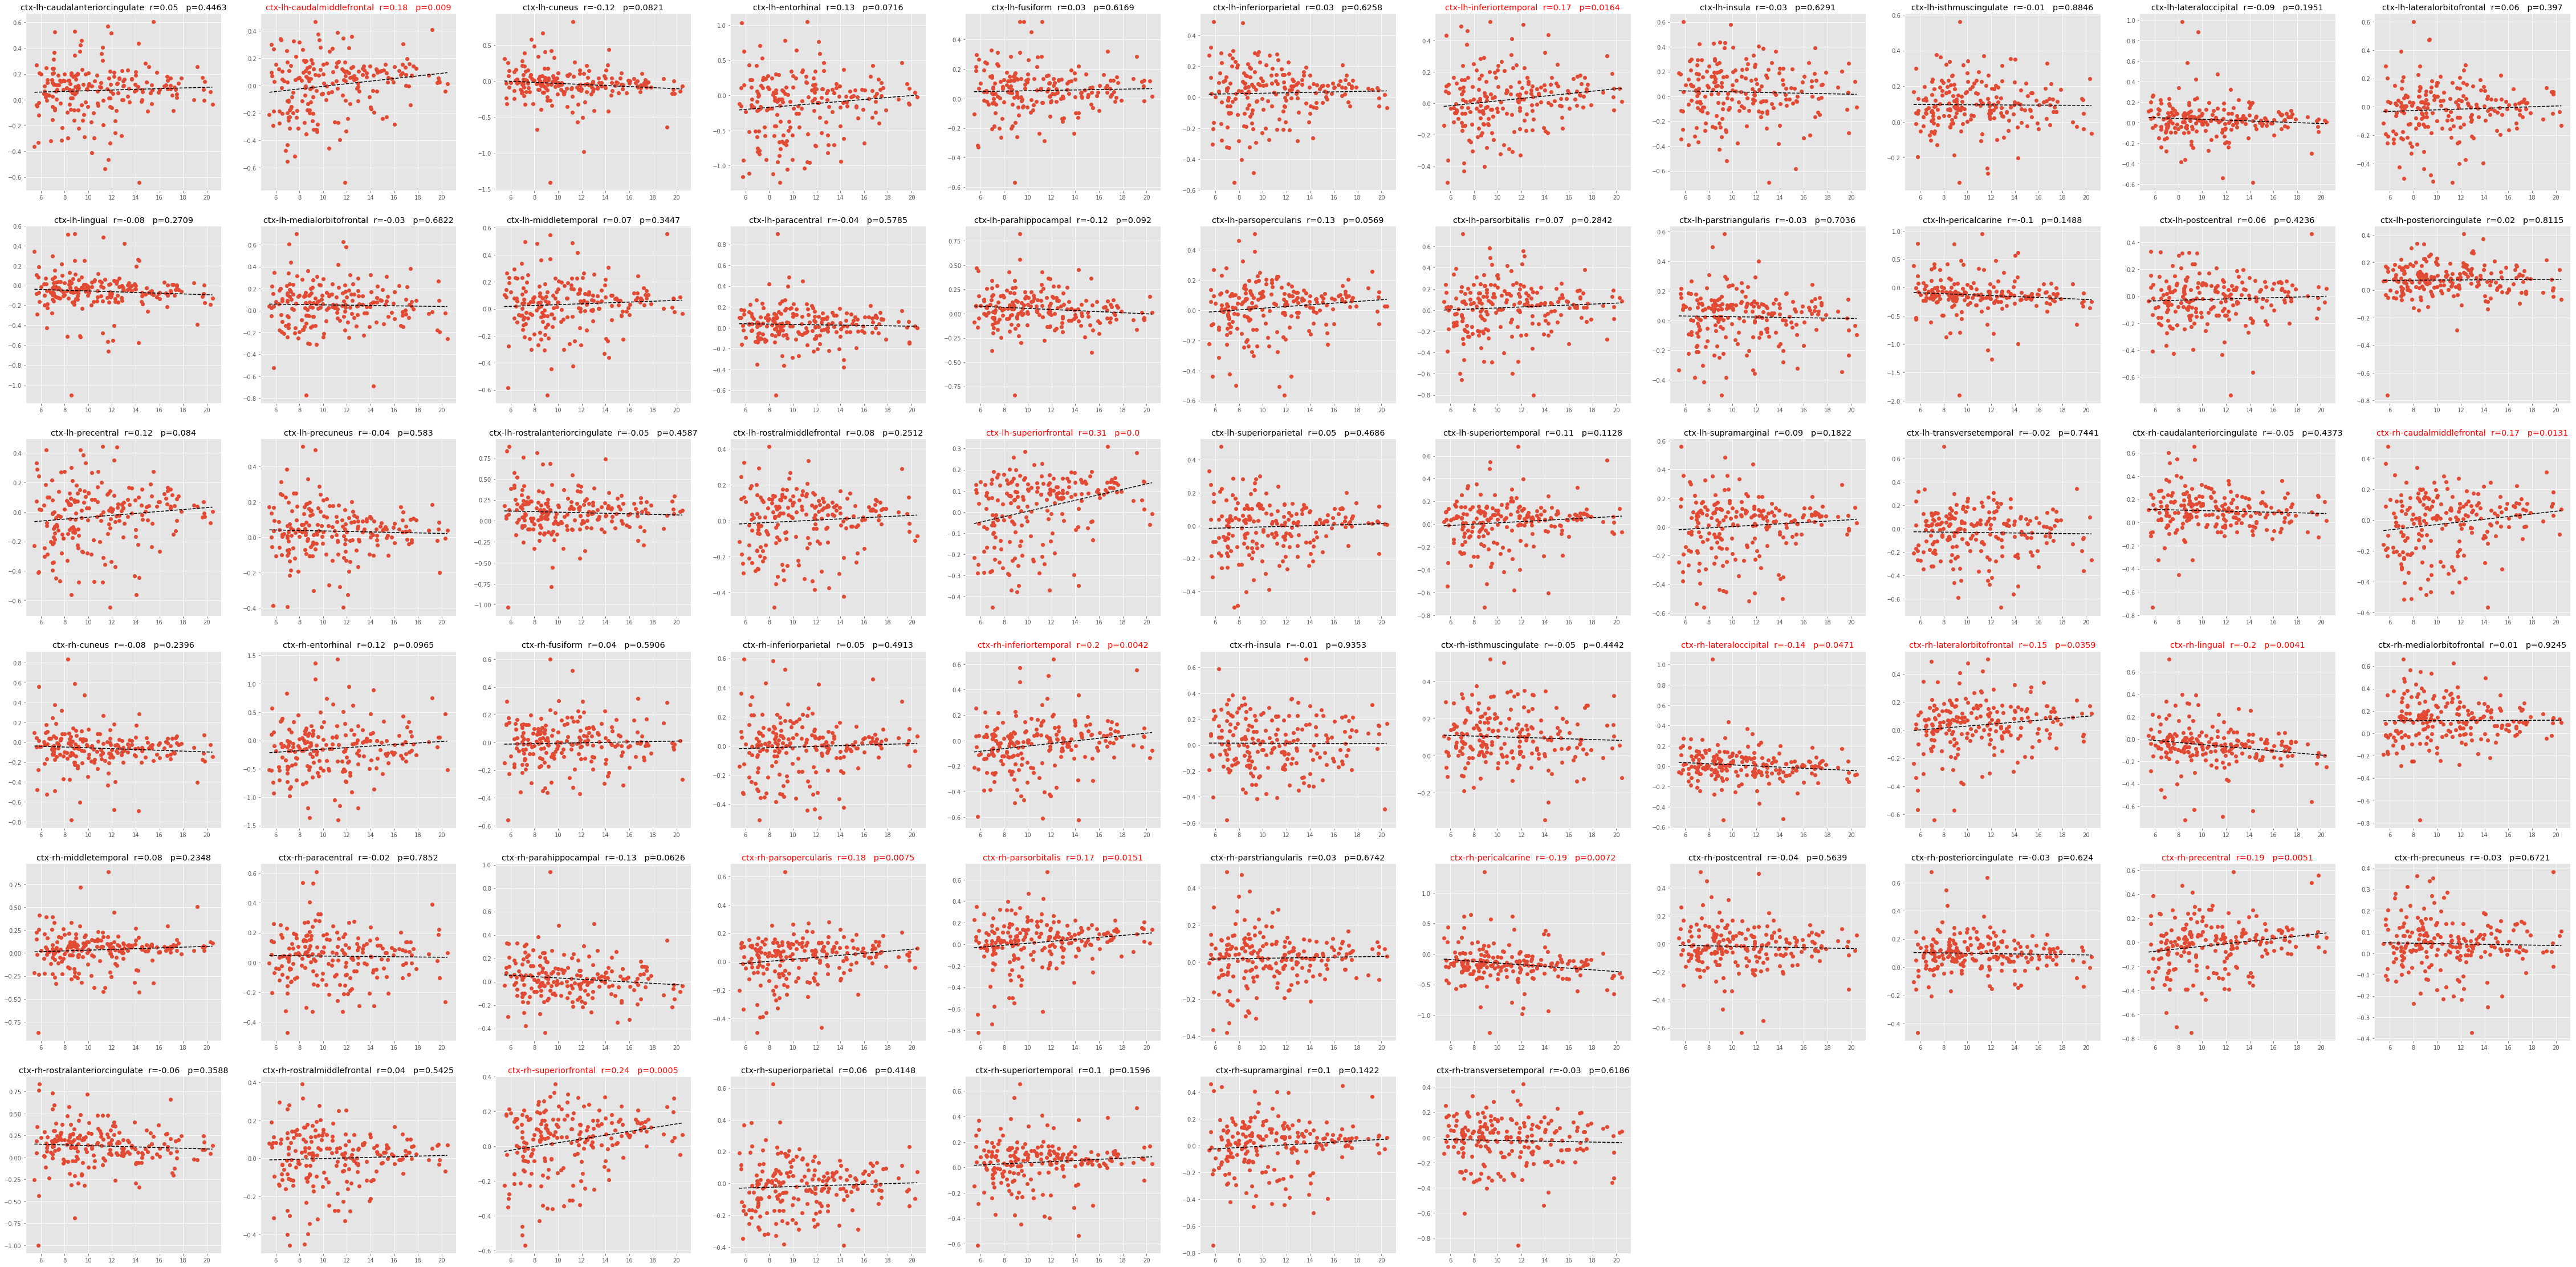

In [175]:
# Learn about API authentication here: https://plot.ly/python/getting-started
# Find your api_key here: https://plot.ly/settings/api

age = np.array(all_male['Age'])
#plt.style.use('seaborn')
plt.style.use('ggplot')

fig = plt.figure(figsize=(80, 40))

# copy the columns of a dataframe 
cortical_thickness_diff_male = pd.DataFrame(data=None, columns=cortical_thickness_HCP_all.columns)

# make a dataframe with the difference in cortical thickness
for name in column_names[0:62]:
    cortical_thickness_diff_male[name] = all_male[name + "_HCP"] - all_male[name + "_vNav"]


for num in np.r_[0: len(column_names)]:
    diff = np.array(cortical_thickness_diff_male[column_names[num]])
    #diff = np.array(cortical_thickness_diff_male[name])
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(age,diff)

 
    fit = np.polyfit(age,diff,1)
    fit_fn = np.poly1d(fit)
    
    plt.subplot(6, 11 , num+1 )
    plt.plot(age,diff, 'o', np.sort(age), fit_fn(np.sort(age)), '--k')
    ax = plt.gca()
    #ax.set_facecolor((0.898, 0.898, 0.898))
    
    if p_value<0.05:
        plt.title(column_names[num] + "  r=" + str(np.around(r_value, decimals=2)) + "   p=" + str(np.around(p_value, decimals=4)),color='r')
        
    else:
        plt.title(column_names[num] + "  r=" + str(np.around(r_value, decimals=2)) + "   p=" + str(np.around(p_value, decimals=4)))
    
                      

plt.savefig("linfit_males.png", transparent=False, dpi=120)


Now for Females

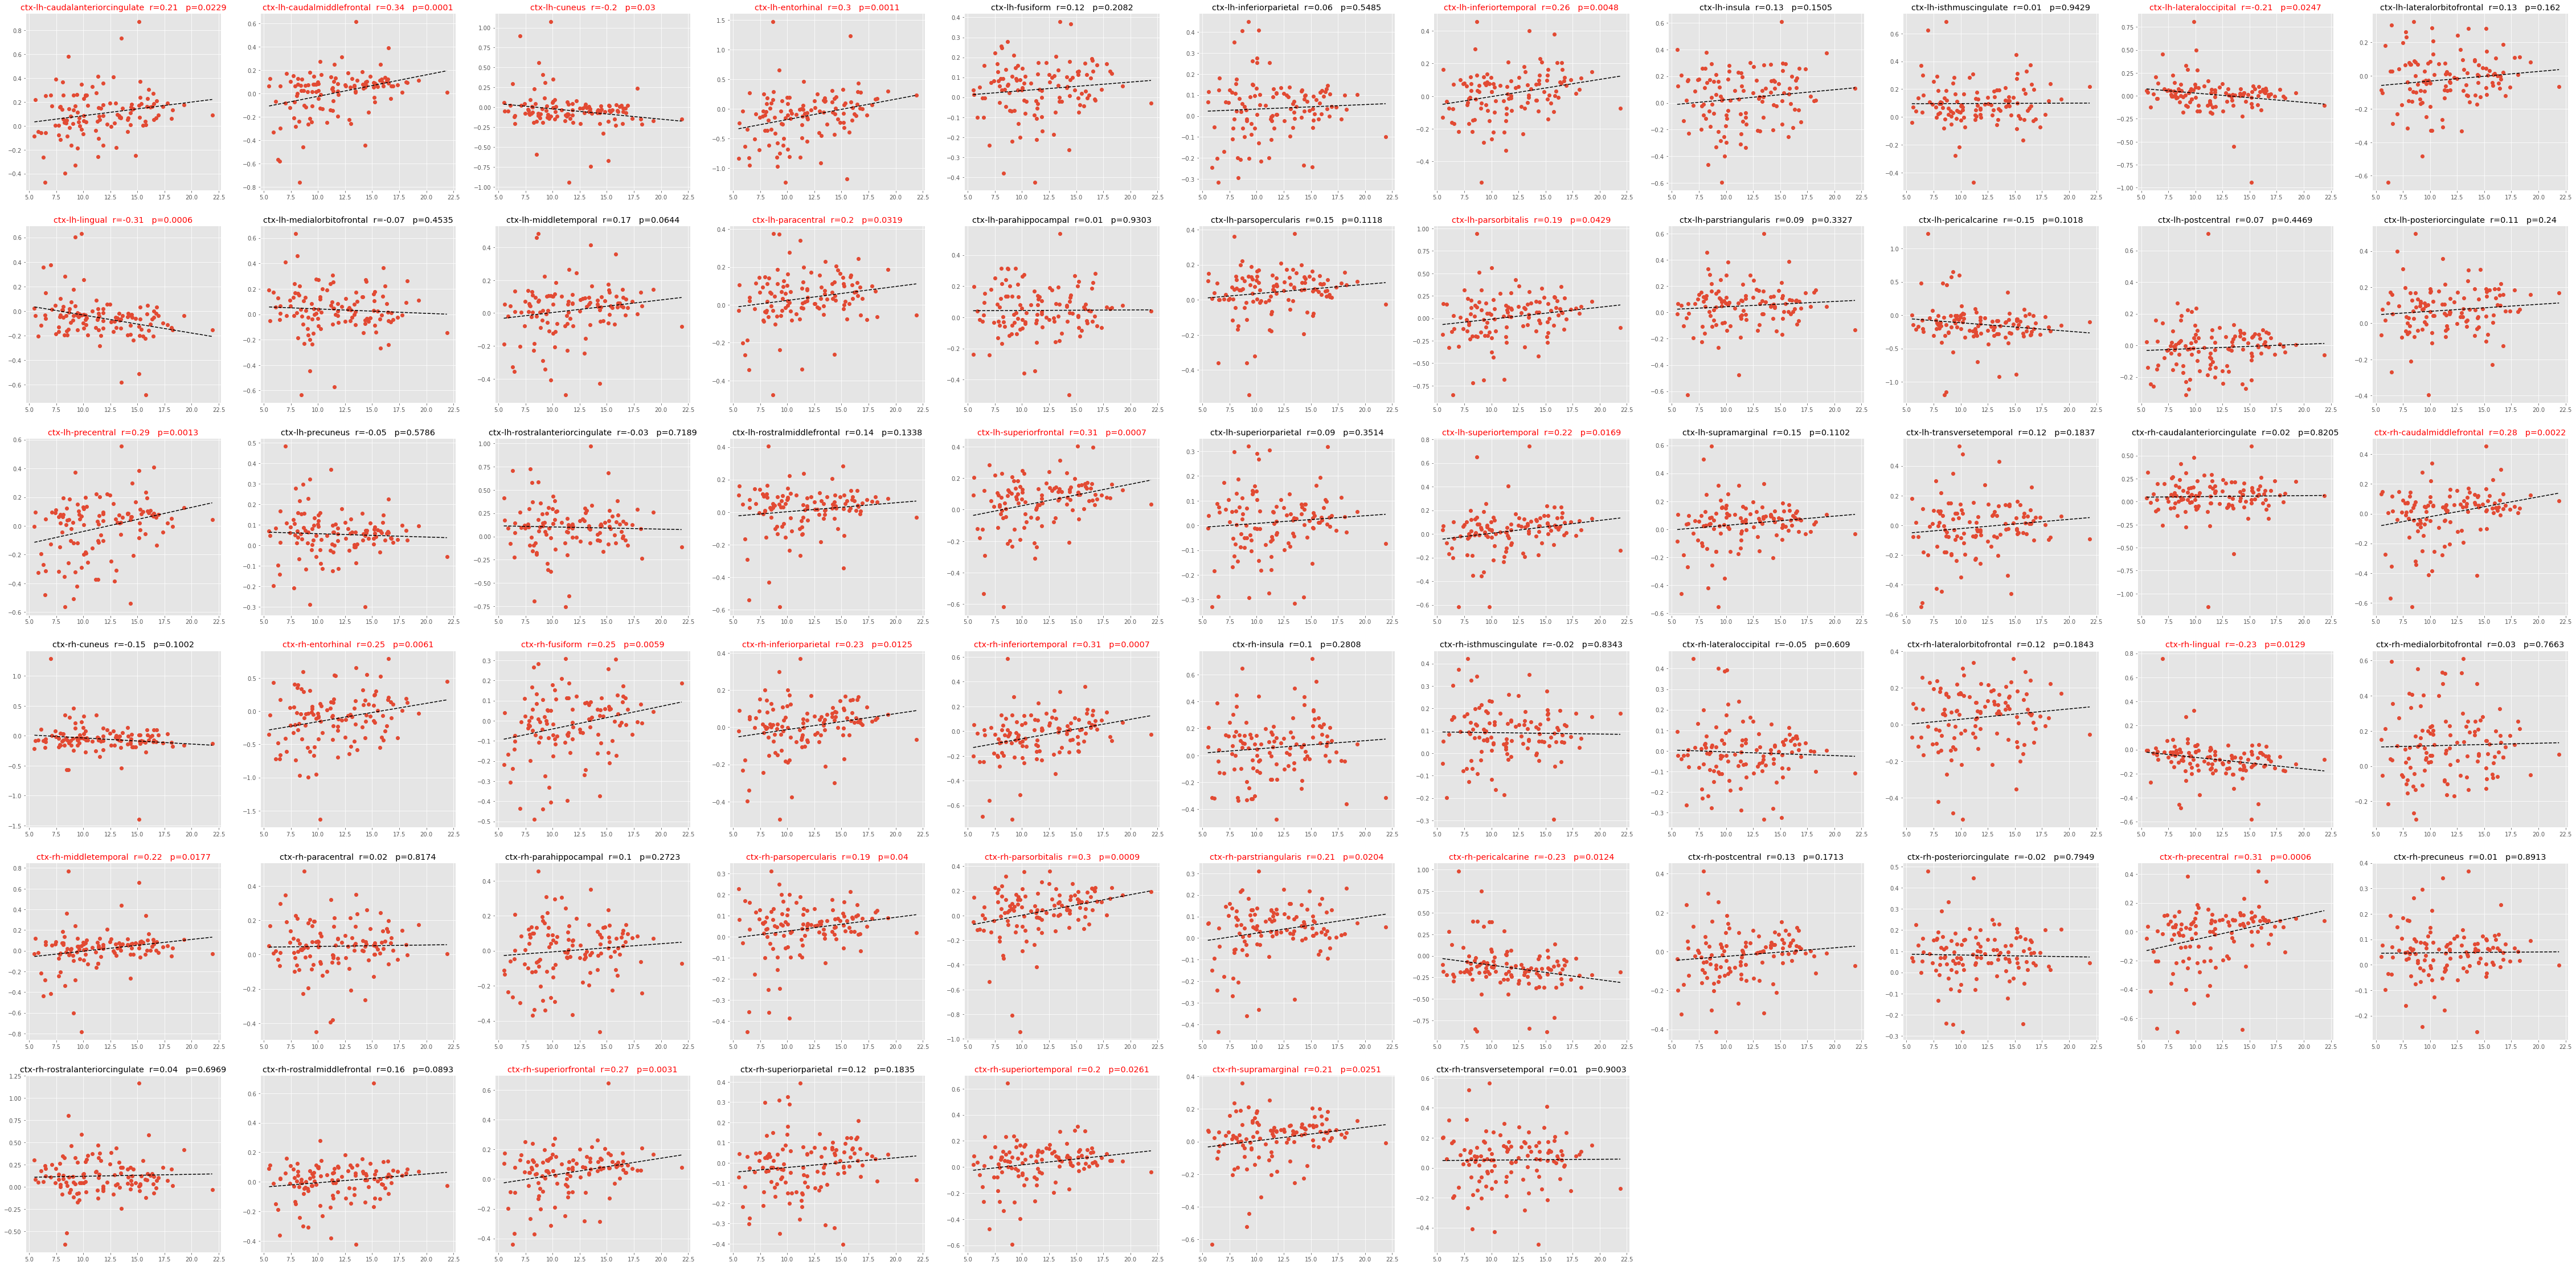

In [160]:
# Learn about API authentication here: https://plot.ly/python/getting-started
# Find your api_key here: https://plot.ly/settings/api

age = np.array(all_female['Age'])
#plt.style.use('seaborn')
plt.style.use('ggplot')

fig = plt.figure(figsize=(80, 40))

# copy the columns of a dataframe 
cortical_thickness_diff_female = pd.DataFrame(data=None, columns=cortical_thickness_HCP_all.columns)

# make a dataframe with the difference in cortical thickness
for name in column_names[0:62]:
    cortical_thickness_diff_female[name] = all_female[name + "_HCP"] - all_female[name + "_vNav"]
    
    


for num in np.r_[0: len(column_names)]:
    diff = np.array(cortical_thickness_diff_female[column_names[num]])
    #diff = np.array(cortical_thickness_diff_male[name])
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(age,diff)

    fit = np.polyfit(age,diff,1)
    fit_fn = np.poly1d(fit)
    
    plt.subplot(6, 11 , num+1 )
    plt.plot(age,diff, 'o', np.sort(age), fit_fn(np.sort(age)), '--k')
    ax = plt.gca()
    #ax.set_facecolor((0.898, 0.898, 0.898))
    
    if p_value<0.05:
        plt.title(column_names[num] + "  r=" + str(np.around(r_value, decimals=2)) + "   p=" + str(np.around(p_value, decimals=4)),color='r')
        
    else:
        plt.title(column_names[num] + "  r=" + str(np.around(r_value, decimals=2)) + "   p=" + str(np.around(p_value, decimals=4)))
    
                      

plt.savefig("linfit_females.png", transparent=False, dpi=120)


# Is there a correlation between motion and age? 

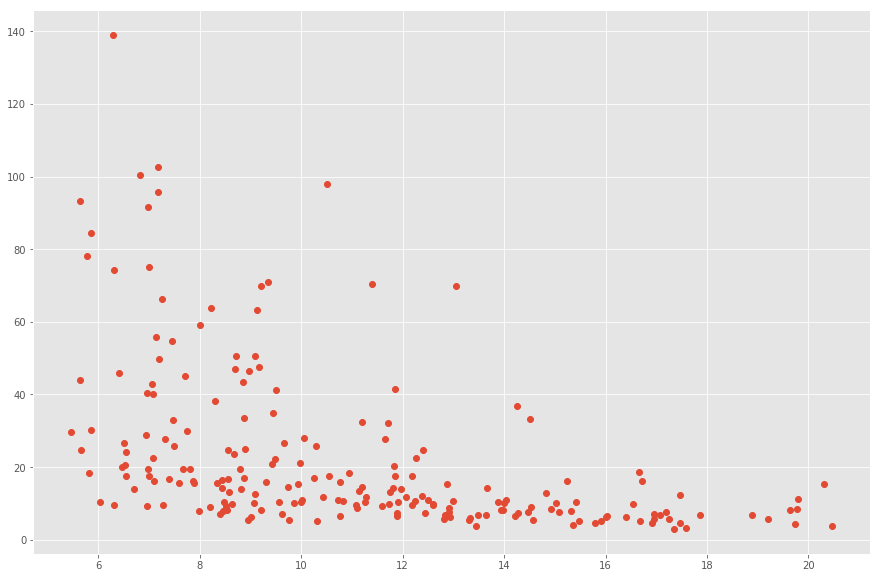

In [182]:
# Need to get the mean motion across rest1, peer1, rest2 movieDM peer3 and movieTB

fig = plt.figure(figsize=(15, 10))
plt.plot(age,all_male['Mean_all'].values, 'o')


fig = plt.figure(figsize=(15, 10))
plt.plot(age,all_male['Mean_all'].values, 'o')




# The rest is scatch

20.466575


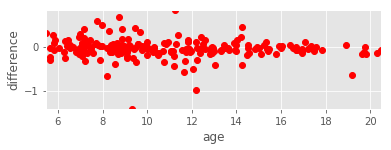

In [149]:
# need to build another database, but now with the differences between MPRAGE and vNav

# copy the columns of a dataframe 
cortical_thickness_diff_male = pd.DataFrame(data=None, columns=cortical_thickness_HCP_all.columns)

#cortical_thickness_HCP_all['ctx-lh-caudalanteriorcingulate'] 

#a = all_male[column_names[0] + "_HCP"] - all_male[column_names[0] + "_vNav"]
#print(a)
#print(list(all_male))

#print(column_names[61])


for name in column_names[0:62]:
    cortical_thickness_diff_male[name] = all_male[name + "_HCP"] - all_male[name + "_vNav"]

#print(cortical_thickness_diff_male[column_names[0]])
diff = np.array(cortical_thickness_diff_male[column_names[2]])

age = np.array(all_male['Age'])

#print(column_names[64]) # 64 is age
print(age.max())

plt.figure()
plt.subplot(211)
plt.plot(age,diff,'ro')
plt.axis([age.min(), age.max(), diff.min(), diff.max()])
plt.xlabel('age')
plt.ylabel('difference')
plt.show()
#    name + "_vNav"
#Example on how to do regression ! 
#http://www.alexsalo.xyz/ancova-comparing-regression-slopes/


0.38126650721170396
0.013480298195440705
0.09713849206748475
0.05101551556934032
0.45199361436542174
0.6310520751079363
0.017833777946078343
0.5648880581617899
0.18959149518809698
0.18393687640210835
0.42638656521692453
0.28396497037063884
0.15740900703525398
0.1989238626160127
0.5248965315448344
0.05682054099890281
0.0640177297593392
0.17560984697135715
0.20859703152948145
0.15821635777879905
0.24443617181318658
0.01839289539672529
0.10898426712718533
0.5655990197667489
0.09095198562092471
0.2202244801935186
3.607270824395072e-06
0.22974128812712252
0.13513139057581772
0.15594360926946618
0.6534146326880539
0.1689814392546494
0.011487153849677583
0.22584429953255997
0.1043407480410005
0.36337230362327644
0.18480273983937479
0.004368843108965039
0.1785430047969475
0.1932315199577722
0.054308875067004
0.012445297880165787
0.005115841283945596
0.09631700449633508
0.20980693452808832
0.7706507081190603
0.055424619165859015
0.004305692954843968
0.010432280707622575
0.6421855973908046
0.011

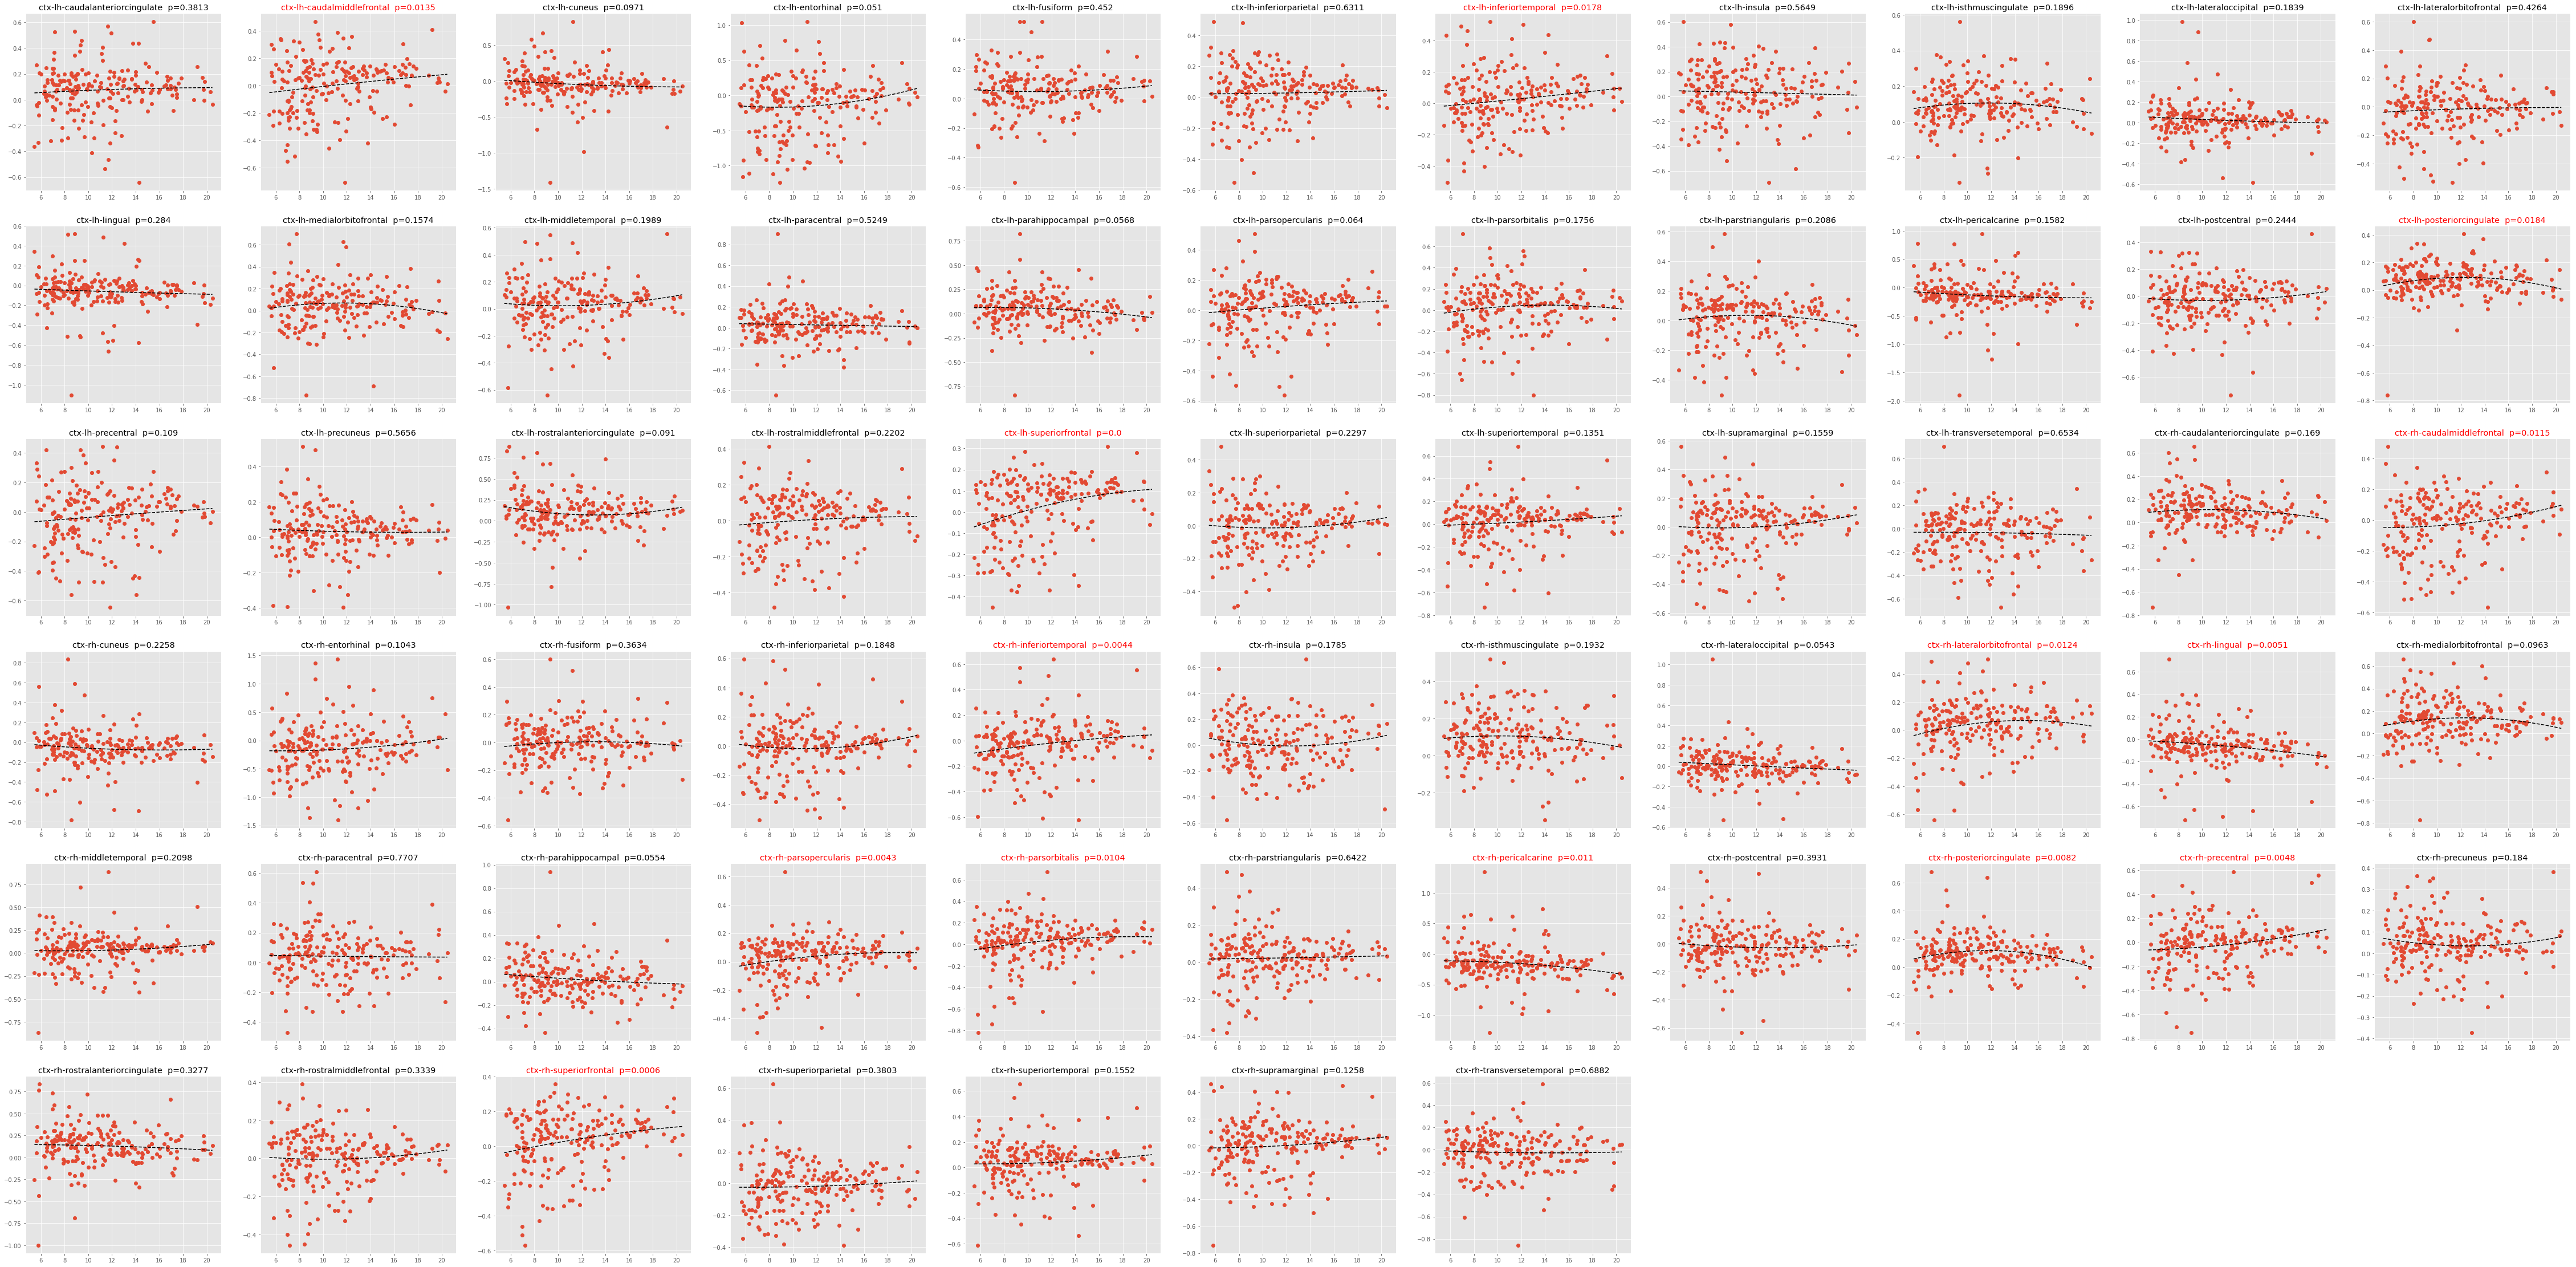

In [109]:
from numpy.polynomial import polynomial as P




age = np.array(all_male['Age'])
#plt.style.use('seaborn')
plt.style.use('ggplot')

#fig = go.Figure()

fig = plt.figure(figsize=(80, 40))


degree = 2

for num in np.r_[0: len(column_names)]:

    diff = np.array(cortical_thickness_diff_male[column_names[num]])
    #diff = np.array(cortical_thickness_diff_male[name])
    

    
    df = pd.DataFrame(columns=['diff', 'age'])
    df['age'] = age
    df['diff'] = diff

    weights = np.polyfit(age, diff, degree)
    model = np.poly1d(weights)
    results = smf.ols(formula='diff ~ model(age)', data=df).fit()


    #plt.plot(age,diff, 'ro', age, model(age), '--k')
    #ax = plt.gca()
    #ax.set_facecolor((0.898, 0.898, 0.898))

    #print(results.summary2())
    print(results.pvalues['model(age)'])
    
  
    
    plt.subplot(6, 11 , num+1 )
    plt.plot(age,diff, 'o', np.sort(age), model(np.sort(age)), '--k')
    ax = plt.gca()
    
    #ax.set_facecolor((0.898, 0.898, 0.898))
    
    #plt.subplot(11, 6 , num+1 )
    #plt.plot(age,diff,'o', age, line)
    p_value = results.pvalues['model(age)']
    
    if p_value<0.05:
        plt.title(column_names[num] + "  p=" + str(np.around(p_value, decimals=4)),color='r')
        
    else:
        plt.title(column_names[num] + "  p=" + str(np.around(p_value, decimals=4)))
    
                  
    #ax = plt.gca()
    #ax.set_facecolor((0.898, 0.898, 0.898))
    #fig = plt.gcf()
    

plt.savefig("2nddegreefit_boys.png", transparent=False, dpi=120)


#print(r_value)
#print(p_value)


#print(len(column_names))
#print(stats_blah)



Now another option to plot

(4, 22)

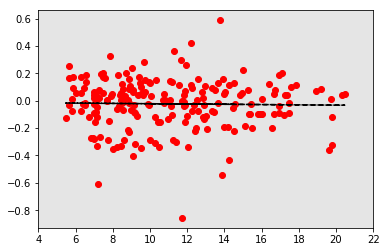

In [113]:

import numpy as np
import matplotlib.pyplot as plt

#x = [1,2,3,4]
#y = [3,5,7,10] # 10, not 9, so the fit isn't perfect

fit = np.polyfit(age,diff,1)
fit_fn = np.poly1d(fit) 
# fit_fn is now a function which takes in x and returns an estimate for y

plt.plot(age,diff, 'ro', age, fit_fn(age), '--k')
ax = plt.gca()
ax.set_facecolor((0.898, 0.898, 0.898))

plt.xlim(4, 22)
#plt.ylim(0, 12)



## The rest is just examples for plotting

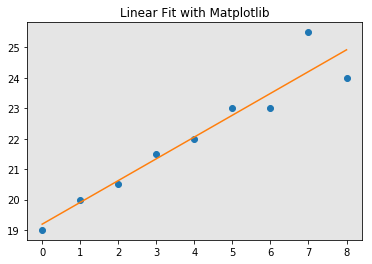

In [24]:
# Learn about API authentication here: https://plot.ly/python/getting-started
# Find your api_key here: https://plot.ly/settings/api

import plotly.plotly as py
import plotly.graph_objs as go

# MatPlotlib
import matplotlib.pyplot as plt
from matplotlib import pylab

# Scientific libraries
from numpy import arange,array,ones
from scipy import stats


xi = arange(0,9)
A = array([ xi, ones(9)])

# (Almost) linear sequence
y = [19, 20, 20.5, 21.5, 22, 23, 23, 25.5, 24]

# Generated linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(xi,y)
line = slope*xi+intercept

plt.plot(xi,y,'o', xi, line)
pylab.title('Linear Fit with Matplotlib')
ax = plt.gca()
ax.set_facecolor((0.898, 0.898, 0.898))
fig = plt.gcf()
#py.plot_mpl(fig, filename='linear-Fit-with-matplotlib')

/Users/afranco/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1416: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=9



<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.907   
Dependent Variable: y                AIC:                18.8077 
Date:               2019-07-23 12:51 BIC:                19.2022 
No. Observations:   9                Log-Likelihood:     -7.4039 
Df Model:           1                F-statistic:        79.44   
Df Residuals:       7                Prob (F-statistic): 4.54e-05
R-squared:          0.919            Scale:              0.39014 
-------------------------------------------------------------------
             Coef.    Std.Err.     t      P>|t|     [0.025   0.975]
-------------------------------------------------------------------
Intercept    0.0000     2.4834   0.0000   1.0000   -5.8722   5.8722
model(xi)    1.0000     0.1122   8.9127   0.0000    0.7347   1.2653
-----------------------------------------------------------------
Omnibus:              9.073        Durbin-Watson:           3.135
Prob(Omnibus):        0.011        Jarque-Bera (JB):        3.237
Skew:                 1.287        Prob(JB):                0.198
Kurtosis:             4.415        Condition No.:           265  
=================================================================

"""

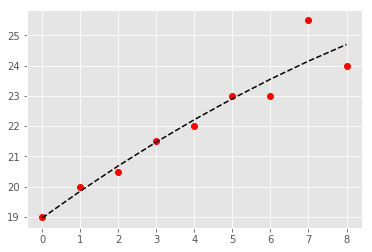

In [117]:
# scratch

# going to do stats based on this:

# https://joshualoong.com/2018/10/03/Fitting-Polynomial-Regressions-in-Python/
xi = arange(0,9)

# (Almost) linear sequence
y = [19, 20, 20.5, 21.5, 22, 23, 23, 25.5, 24]


## One way of doing things
slope, intercept, r_value, p_value, std_err = stats.linregress(xi,y)
line = slope*xi+intercept

#plt.plot(xi,y,'o', xi, line)
#pylab.title('Linear Fit with Matplotlib')
#ax = plt.gca()
#ax.set_facecolor((0.898, 0.898, 0.898))
#fig = plt.gcf()

## Another  (2nd) way of doing linear regression 
fit = np.polyfit(xi,y,2)    # <--- do this method

fit_fn = np.poly1d(fit) 

# fit_fn is now a function which takes in x and returns an estimate for y

#plt.plot(xi,y, 'ro', xi, fit_fn(xi), '--k')
#ax = plt.gca()
#ax.set_facecolor((0.898, 0.898, 0.898))

#plt.xlim(4, 22)


## now a 3rd way of doing linear regression 
    
fit_blah, stats_blah = P.polyfit(xi,y,1,full=True)
fit_blah = fit_blah[::-1]



# Now really geting thet stats 
import statsmodels.formula.api as smf


degree = 2

df = pd.DataFrame(columns=['y', 'xi'])
df['xi'] = xi
df['y'] = y

weights = np.polyfit(xi, y, degree)
model = np.poly1d(weights)
results = smf.ols(formula='y ~ model(xi)', data=df).fit()


plt.plot(xi,y, 'ro', xi, model(xi), '--k')
ax = plt.gca()
ax.set_facecolor((0.898, 0.898, 0.898))

results.summary2()
print(results.pvalues['model(xi)'])

(0, 12)

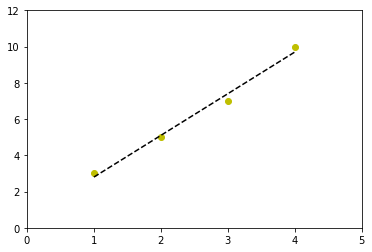

In [83]:
import numpy as np
import matplotlib.pyplot as plt

x = [1,2,3,4]
y = [3,5,7,10] # 10, not 9, so the fit isn't perfect

fit = np.polyfit(x,y,1)
fit_fn = np.poly1d(fit) 
# fit_fn is now a function which takes in x and returns an estimate for y

plt.plot(x,y, 'yo', x, fit_fn(x), '--k')
plt.xlim(0, 5)
plt.ylim(0, 12)